# Generating Music with RNN

Sources:
- https://www.tensorflow.org/tutorials/audio/music_generation

## Setup

In [1]:
!sudo apt install -y fluidsynth
%pip install --upgrade pyfluidsynth
%pip install pretty_midi

[sudo] password for keegan-jebb: 
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from tqdm import tqdm

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [10]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [11]:
import os
import urllib.request
import zipfile
from pathlib import Path

# Define the directory where data will be stored
# data_dir = Path('data/maestro-v2.0.0')
data_dir = Path('/home/keegan-jebb/Documents/projects/misc_data/maestro-v3.0.0')

# Check if the data directory already exists
if not data_dir.exists():
    os.makedirs(data_dir)

    # URL of the file to be downloaded
    url = 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'

    # Define the local path where the zip file will be saved
    zip_path = Path('data/maestro-v2.0.0-midi.zip')

    # Download the file from the given URL
    print(f'Downloading {url}...')
    urllib.request.urlretrieve(url, zip_path)

    # Extract the contents of the zip file
    print('Extracting files...')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data/')

    # Remove the zip file after extraction
    os.remove(zip_path)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## MIDI Processing

In [13]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


In [14]:
# from google.colab import files
sample_file = filenames[1]
print(sample_file)
# files.download(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

/home/keegan-jebb/Documents/projects/misc_data/maestro-v3.0.0/2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--2.midi


In [15]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [16]:
display_audio(pm)

In [17]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
print('Program:', instrument.program)
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

Number of instruments: 1
Program: 0
Instrument name: Acoustic Grand Piano
0: pitch=63, note_name=D#4, duration=0.3346
1: pitch=39, note_name=D#2, duration=0.1654
2: pitch=58, note_name=A#3, duration=0.1367
3: pitch=46, note_name=A#2, duration=0.2148
4: pitch=51, note_name=D#3, duration=0.1549
5: pitch=54, note_name=F#3, duration=0.1914
6: pitch=46, note_name=A#2, duration=0.0768
7: pitch=39, note_name=D#2, duration=0.0846
8: pitch=51, note_name=D#3, duration=0.0534
9: pitch=54, note_name=F#3, duration=0.0599


In [18]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [19]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     63  0.278646  0.613281  0.000000  0.334635
1     39  0.945312  1.110677  0.666667  0.165365
2     46  0.945312  1.160156  0.000000  0.214844
3     58  1.006510  1.143229  0.061198  0.136719
4     51  1.014323  1.169271  0.007812  0.154948

In [20]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'D#2', 'A#2', 'A#3', 'D#3', 'F#3', 'A#2', 'A#3', 'D#2',
       'D#3'], dtype='<U3')

In [21]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [22]:
a = np.stack([raw_notes['pitch'], raw_notes['pitch']], axis=0)
print(a)
a = np.stack([raw_notes['start'], raw_notes['end']], axis=0)
print(a)

[[63 39 46 ... 46 55 63]
 [63 39 46 ... 46 55 63]]
[[2.78645833e-01 9.45312500e-01 9.45312500e-01 ... 2.85233073e+02
  2.85622396e+02 2.86479167e+02]
 [6.13281250e-01 1.11067708e+00 1.16015625e+00 ... 2.91421875e+02
  2.90856771e+02 2.91858073e+02]]


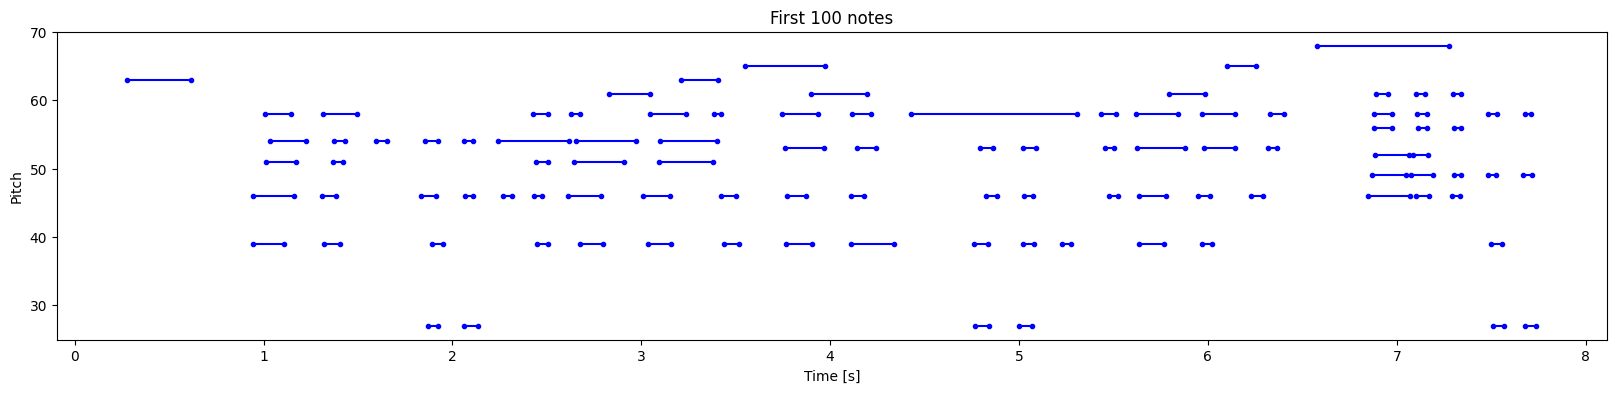

In [23]:
plot_piano_roll(raw_notes, 100)

In [24]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  min_step = np.percentile(notes['step'], drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(min_step, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  min_duration = np.percentile(notes['duration'], drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(min_duration, max_duration, 21))

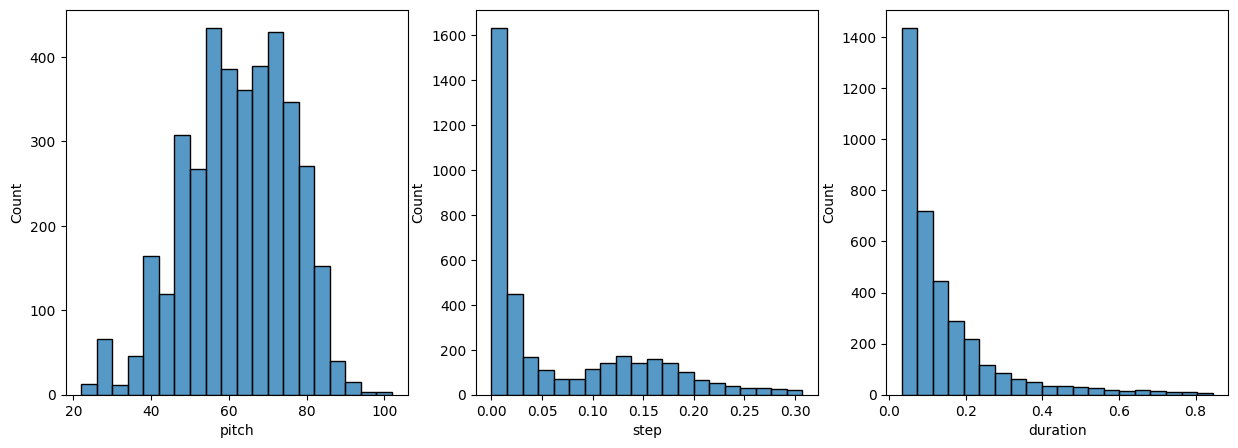

In [25]:
plot_distributions(raw_notes)

In [26]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [27]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [28]:
display_audio(example_pm)

## Data Processing

In [29]:
def get_midi_data(filenames, num_files):
    all_notes = []
    file_id = 0
    for f in filenames[:num_files]:
        notes = midi_to_notes(f)
        notes['file_id'] = file_id
        all_notes.append(notes)
        file_id += 1

    return all_notes

In [30]:
num_files = 50
all_notes = get_midi_data(filenames, num_files)

all_notes_cat = pd.concat(all_notes)

n_notes = len(all_notes_cat)                
print('Number of notes parsed:', n_notes)

all_notes_cat.head(26)

Number of notes parsed: 466406


pitch     start       end      step  duration  file_id
0      22  0.955729  1.052083  0.000000  0.096354        0
1      34  0.962240  1.078125  0.006510  0.115885        0
2      41  1.299479  1.417969  0.337240  0.118490        0
3      46  1.423177  1.606771  0.123698  0.183594        0
4      50  1.531250  1.638021  0.108073  0.106771        0
5      52  1.658854  1.696615  0.127604  0.037760        0
6      53  1.764323  1.885417  0.105469  0.121094        0
7      58  1.886719  2.013021  0.122396  0.126302        0
8      62  1.889323  1.986979  0.002604  0.097656        0
9      55  2.013021  2.141927  0.123698  0.128906        0
10     53  2.123698  2.157552  0.110677  0.033854        0
11     50  2.260417  2.348958  0.136719  0.088542        0
12     46  2.389323  2.429688  0.128906  0.040365        0
13     41  2.430990  2.550781  0.041667  0.119792        0
14     34  2.575521  2.678385  0.144531  0.102865        0
15     41  2.678385  2.825521  0.102865  0.147135        0
16     46  2.792969  2.901042  0.114583  0.108073        0
17     50  2.890625  2.936198  0.097656  0.045573        0
18     52  3.022135  3.132812  0.131510  0.110677        0
19     53  3.111979  3.213542  0.089844  0.101562        0
20     62  3.205729  3.300781  0.093750  0.095052        0
21     58  3.209635  3.324219  0.003906  0.114583        0
22     55  3.324219  3.429688  0.114583  0.105469        0
23     53  3.446615  3.476562  0.122396  0.029948        0
24     50  3.533854  3.630208  0.087240  0.096354        0
25     46  3.631510  3.716146  0.097656  0.084635        0

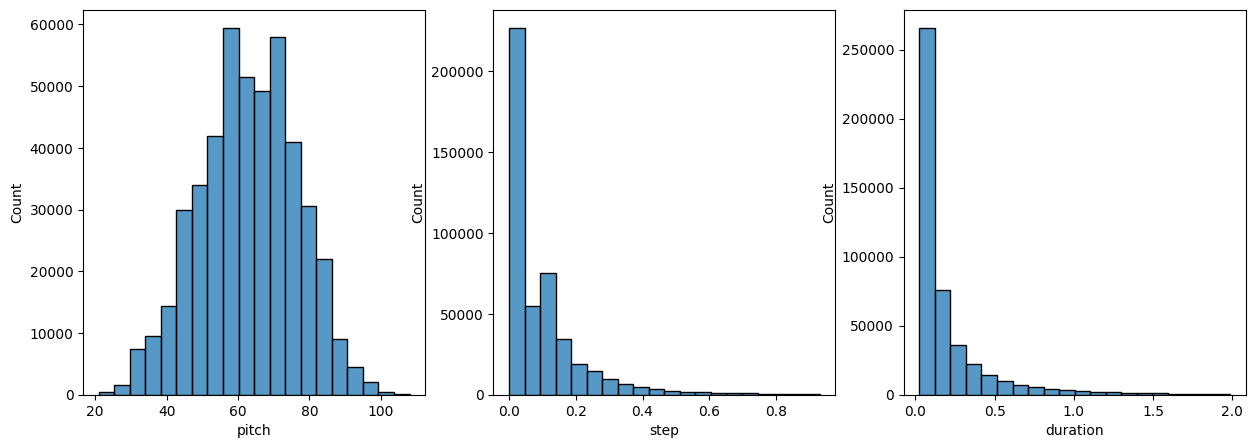

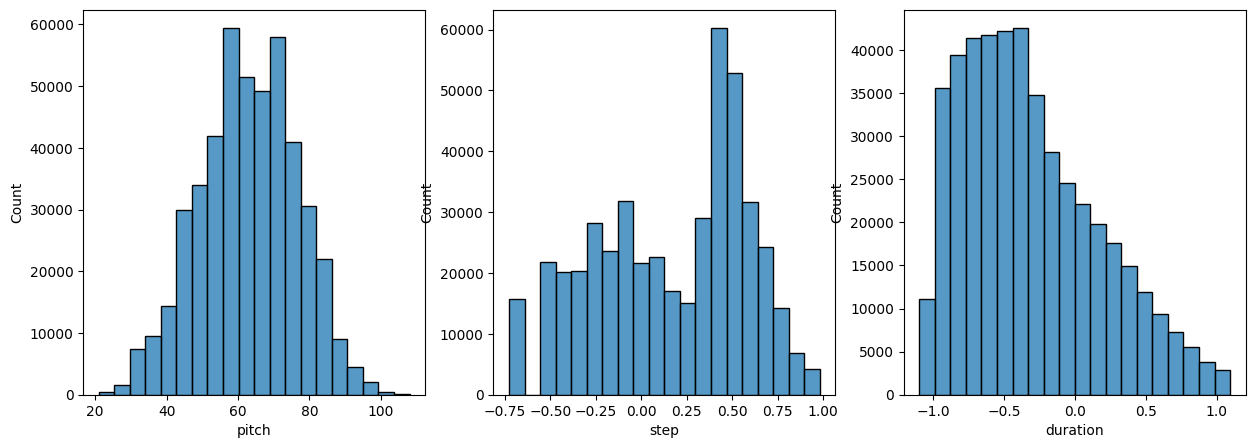

In [32]:
plot_distributions(all_notes_cat, 1)
all_notes_cat['step'] = (np.log(all_notes_cat['step']+0.001) + 4) / 4
all_notes_cat['duration'] = (np.log(all_notes_cat['duration']) + 1.5) / 2
plot_distributions(all_notes_cat, 1)

## Train/Val/Test Sets

In [33]:
seq_length = 25
vocab_size = 128
take_last = False
key_order = ['pitch', 'step', 'duration']

In [34]:
def log_transform(seq):
    seq[:, 1] = (np.log(seq[:, 1] + 0.001) + 4) / 4
    seq[:, 2] = (np.log(seq[:, 2]) + 1.5) / 2
    return seq

In [35]:
from torch.utils.data import Dataset, random_split, DataLoader

class MidiSequenceDataset(Dataset):
    def __init__(self, all_notes, seq_length, vocab_size=128, take_last=True, transform=None):
        self.seq_length = seq_length + 1  # Include 1 extra for labels
        self.vocab_size = vocab_size
        self.transform = transform
        self.sequences = self.create_sequences(all_notes)

    def create_sequences(self, all_notes):
        sequences = []
        key_order = ['pitch', 'step', 'duration']
        for notes in all_notes:
            notes = notes[key_order]
            for i in range(len(notes) - self.seq_length + 1):
                seq = torch.tensor(notes[i:i + self.seq_length].values, dtype=torch.float32)
                if self.transform is not None:
                    seq = self.transform(seq)
                sequences.append(seq)
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        input = sequence[:-1].clone()
        input[:, 0] = input[:, 0] / self.vocab_size * 2 - 1
        targets = {
            'pitch': sequence[1:, 0].to(torch.long).unsqueeze(-1),
            'step': sequence[1:, 1].unsqueeze(-1),
            'duration': sequence[1:, 2].unsqueeze(-1)
        }
        if take_last:
            for key in targets:
                targets[key] = targets[key][-1].unsqueeze(-1)
        return input, targets

In [36]:
midi_ds = MidiSequenceDataset(all_notes, seq_length, vocab_size, take_last, log_transform)
print(len(midi_ds))

465156


In [37]:
midi_iter = iter(midi_ds)
seq, target = next(midi_iter)
print('sequence shape:', seq.shape)
print('sequence elements (first 10):', seq[0: 10])
print()
print('target:', target)
print(target['pitch'].shape, target['step'].shape, target['duration'].shape)

sequence shape: torch.Size([25, 3])
sequence elements (first 10): tensor([[-0.6562, -0.7269, -0.4199],
        [-0.4688, -0.2229, -0.3276],
        [-0.3594,  0.7290, -0.3165],
        [-0.2812,  0.4795, -0.0975],
        [-0.2188,  0.4461, -0.3685],
        [-0.1875,  0.4872, -0.8882],
        [-0.1719,  0.4400, -0.3056],
        [-0.0938,  0.4769, -0.2845],
        [-0.0312, -0.4064, -0.4132],
        [-0.1406,  0.4795, -0.2743]])

target: {'pitch': tensor([[34],
        [41],
        [46],
        [50],
        [52],
        [53],
        [58],
        [62],
        [55],
        [53],
        [50],
        [46],
        [41],
        [34],
        [41],
        [46],
        [50],
        [52],
        [53],
        [62],
        [58],
        [55],
        [53],
        [50],
        [46]]), 'step': tensor([[-0.2229],
        [ 0.7290],
        [ 0.4795],
        [ 0.4461],
        [ 0.4872],
        [ 0.4400],
        [ 0.4769],
        [-0.4064],
        [ 0.4795],
        [ 0.4

In [38]:
# Define the split sizes (e.g., 80% training, 20% validation)
training_ratio = 0.8
batch_size = 64

train_size = int(training_ratio * len(midi_ds))
val_size = len(midi_ds) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(midi_ds, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(len(train_loader))
print(len(val_loader))

5815
1454


## RNN Model

In [39]:
class MidiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_state_dim, layer_dim, dropout, out_dims, take_last=True):
        super().__init__()
        self.hidden_state_dim = hidden_state_dim
        self.layer_dim = layer_dim
        self.take_last = take_last

        self.lstm = nn.LSTM(input_dim, hidden_state_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc_pitch = nn.Linear(hidden_state_dim, out_dims['pitch'])
        self.fc_step = nn.Linear(hidden_state_dim, out_dims['step'])
        self.fc_duration = nn.Linear(hidden_state_dim, out_dims['duration'])

    def forward(self, x):
        batch_dim, seq_dim, _ = x.size()
        h0 = torch.zeros(self.layer_dim, batch_dim, self.hidden_state_dim).to(device)
        c0 = torch.zeros(self.layer_dim, batch_dim, self.hidden_state_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0)) # (N, L, H)
        out_pitch = self.fc_pitch(out) # (N, L, 128)
        out_step = self.fc_step(out) # (N, L, 1)
        out_duration = self.fc_duration(out) # (N, L, 1)
        outputs = {'pitch': out_pitch, 'step': out_step, 'duration': out_duration}
        if self.take_last:
            for key in outputs:
                outputs[key] = outputs[key][:, -1].unsqueeze(1) # Keep the L dimension
        return outputs

In [40]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def print_model_params(model):
    print("")
    print(model)
    print("")

    print("Check layers properties")
    for i, properties in enumerate(model.named_parameters()):
        print("Model layer: {} -  name: {} - requires_grad: {} ".format(i, properties[0], properties[1].requires_grad))
    print("")

    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("pytorch_total_params: ", pytorch_total_params)
    print("pytorch_total_trainable_params: ", pytorch_total_trainable_params)

    print("")
    
    count_parameters(model)

## Training

In [41]:
def mse_with_positive_pressure(outputs, targets):
    mse = (targets - outputs) ** 2
    positive_pressure = 10 * torch.maximum(-outputs, torch.tensor(0.0))
    return torch.mean(mse + positive_pressure)

class MidiLoss(nn.Module):
    def __init__(self, w_loss, loss_fns):
        super().__init__()
        self.w_loss = w_loss
        self.loss_fns = loss_fns

    def forward(self, outputs, targets):
        # reshape for cross entropy loss
        N, L, C = outputs['pitch'].shape
        outputs['pitch'] = outputs['pitch'].view(N * L, C)
        targets['pitch'] = targets['pitch'].view(N * L)
        pitch_loss = self.loss_fns['pitch'](outputs['pitch'], targets['pitch']) * self.w_loss['pitch']

        step_loss = self.loss_fns['step'](outputs['step'], targets['step']) * self.w_loss['step']
        duration_loss = self.loss_fns['duration'](outputs['duration'], targets['duration']) * self.w_loss['duration']
        loss = pitch_loss + step_loss + duration_loss
        return loss, [pitch_loss, step_loss, duration_loss]

In [42]:
import torch.optim as optim

input_dim = seq.shape[1]
out_dims = {
    'pitch': 128,
    'step': 1,
    'duration': 1
}
hidden_state_dim = 512
layer_dim = 1
dropout = 0

model = MidiLSTM(input_dim, hidden_state_dim, layer_dim, dropout, out_dims, take_last)
model.to(device)
print_model_params(model)

loss_weights = {
    'pitch': 0.1,
    'step': 2.0,
    'duration': 1.0
}

# MSE for normalized timing
# mse_with_positive_pressure for original timing
loss_fns = {
    'pitch': nn.CrossEntropyLoss(),
    'step': nn.MSELoss(),
    'duration': nn.MSELoss()
}

learning_rate = 1e-4

criterion = MidiLoss(loss_weights, loss_fns)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create directories for saving checkpoints
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

n_epochs = 100
print_progess = 2000

# Early stopping parameters
patience = 70
best_loss = float('inf')
patience_counter = 0


MidiLSTM(
  (lstm): LSTM(3, 512, batch_first=True)
  (fc_pitch): Linear(in_features=512, out_features=128, bias=True)
  (fc_step): Linear(in_features=512, out_features=1, bias=True)
  (fc_duration): Linear(in_features=512, out_features=1, bias=True)
)

Check layers properties
Model layer: 0 -  name: lstm.weight_ih_l0 - requires_grad: True 
Model layer: 1 -  name: lstm.weight_hh_l0 - requires_grad: True 
Model layer: 2 -  name: lstm.bias_ih_l0 - requires_grad: True 
Model layer: 3 -  name: lstm.bias_hh_l0 - requires_grad: True 
Model layer: 4 -  name: fc_pitch.weight - requires_grad: True 
Model layer: 5 -  name: fc_pitch.bias - requires_grad: True 
Model layer: 6 -  name: fc_step.weight - requires_grad: True 
Model layer: 7 -  name: fc_step.bias - requires_grad: True 
Model layer: 8 -  name: fc_duration.weight - requires_grad: True 
Model layer: 9 -  name: fc_duration.bias - requires_grad: True 

pytorch_total_params:  1125506
pytorch_total_trainable_params:  1125506

+---------------

In [43]:
# Test on one example
inputs, targets = next(iter(train_loader))
print(inputs.shape)
print(targets['pitch'].shape, targets['step'].shape, targets['duration'].shape)
outputs = model(inputs.to(device))
print(outputs['pitch'].shape, outputs['step'].shape, outputs['duration'].shape)

targets = {key: target.to(device) for key, target in targets.items()}
criterion(outputs, targets)

torch.Size([64, 25, 3])
torch.Size([64, 25, 1]) torch.Size([64, 25, 1]) torch.Size([64, 25, 1])
torch.Size([64, 25, 128]) torch.Size([64, 25, 1]) torch.Size([64, 25, 1])


(tensor(1.2928, device='cuda:0', grad_fn=<AddBackward0>),
 [tensor(0.4852, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(0.4187, device='cuda:0', grad_fn=<MulBackward0>),
  tensor(0.3889, device='cuda:0', grad_fn=<MulBackward0>)])

In [44]:
# History tracking
losses = {'training': [], 'val': []}

for epoch in range(n_epochs):
    running_loss = 0.0
    epoch_loss = 0.0
    df_loss = pd.DataFrame(columns=['pitch_loss', 'step_loss', 'duration_loss'])
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = {key: target.to(device) for key, target in targets.items()}

        optimizer.zero_grad()
        outputs = model(inputs)
        loss, details = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        details = [l.item() for l in details]
        df_loss.loc[len(df_loss)] = details

        if i % print_progess == (print_progess - 1):
            loss_details_str = ', '.join([f'{col}: {mean:.3f}' for col, mean in df_loss.mean().items()])
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_progess:.3f}, {loss_details_str}')
            running_loss = 0.0
            df_loss.drop(df_loss.index, inplace=True)

    val_loss = 0.0
    df_val_loss = pd.DataFrame(columns=['pitch_loss', 'step_loss', 'duration_loss'])
    for _, data in enumerate(val_loader):
        with torch.no_grad():
            inputs, targets = data
            inputs = inputs.to(device)
            targets = {key: target.to(device) for key, target in targets.items()}

            outputs = model(inputs)
            loss, details = criterion(outputs, targets)

            val_loss += loss.item()
            details = [l.item() for l in details]
            df_val_loss.loc[len(df_val_loss)] = details

    avg_training_loss = epoch_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    losses['training'].append(avg_training_loss)
    losses['val'].append(avg_val_loss)

    val_loss_details_str = ', '.join([f'{col}: {mean:.3f}' for col, mean in df_val_loss.mean().items()])
    print(f'epoch: {epoch + 1}, training_loss: {avg_training_loss:.3f}, val_loss: {avg_val_loss:.3f}, {val_loss_details_str}')

    # Save checkpoint
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'ckpt_epoch_{epoch}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")
    else:
        # Early stopping
        patience_counter += 1
        print(f"Early stopping patience counter: {patience_counter}/{patience}")

        # Early stopping trigger
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print('Finished Training')


[1,  2000] loss: 0.885, pitch_loss: 0.411, step_loss: 0.312, duration_loss: 0.162
[1,  4000] loss: 0.844, pitch_loss: 0.392, step_loss: 0.304, duration_loss: 0.149
epoch: 1, training_loss: 0.854, val_loss: 0.824, pitch_loss: 0.388, step_loss: 0.290, duration_loss: 0.146
Checkpoint saved at ./training_checkpoints/ckpt_epoch_0.pth
[2,  2000] loss: 0.817, pitch_loss: 0.387, step_loss: 0.285, duration_loss: 0.145
[2,  4000] loss: 0.806, pitch_loss: 0.387, step_loss: 0.275, duration_loss: 0.144
epoch: 2, training_loss: 0.807, val_loss: 0.793, pitch_loss: 0.385, step_loss: 0.265, duration_loss: 0.143
Checkpoint saved at ./training_checkpoints/ckpt_epoch_1.pth
[3,  2000] loss: 0.787, pitch_loss: 0.384, step_loss: 0.260, duration_loss: 0.142
[3,  4000] loss: 0.779, pitch_loss: 0.383, step_loss: 0.255, duration_loss: 0.142
epoch: 3, training_loss: 0.779, val_loss: 0.768, pitch_loss: 0.380, step_loss: 0.248, duration_loss: 0.141
Checkpoint saved at ./training_checkpoints/ckpt_epoch_2.pth
[4,  20

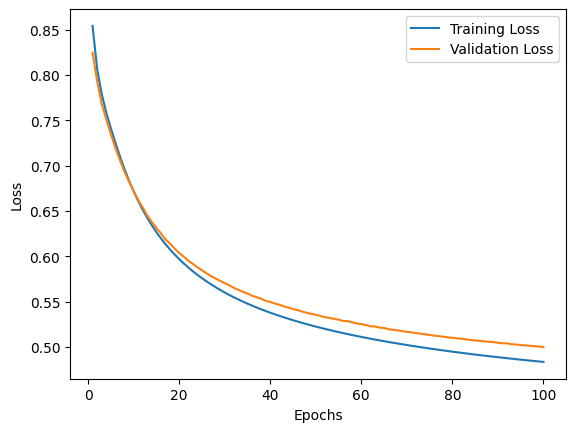

In [45]:
# Plot the training history
plt.plot(range(1, len(losses['training']) + 1), losses['training'], label='Training Loss')
plt.plot(range(1, len(losses['val']) + 1), losses['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')  
plt.legend()
plt.show()

## Generation

In [46]:
def predict_next_note(inputs, model, temperature=1.0):
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    model.eval()
    with torch.no_grad():
        preds = model(inputs)
        
        pitch_logits = preds['pitch'][:, -1, :] # N, C
        pitch_logits /= temperature
        pitch = torch.multinomial(F.softmax(pitch_logits, dim=-1), num_samples=1)
        pitch = pitch / vocab_size * 2 - 1

        step = preds['step'][:, -1, :] # N, C
        duration = preds['duration'][:, -1, :] # N, C

    return torch.cat([pitch, step, duration], axis=1).unsqueeze(1)

In [47]:
temperature = 1.0
num_predictions = 120

inputs, _ = next(iter(train_loader))
inputs = inputs[0].unsqueeze(0).to(device)

for _ in range(num_predictions):
    next_note = predict_next_note(inputs[:, -seq_length:, :], model, temperature)
    inputs = torch.cat((inputs, next_note), axis=1)

In [48]:
N, L, C = inputs.shape
generated_notes = np.zeros((L, C + 2))
generated_notes[:, :3] = inputs.cpu().numpy()[0]
generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes['pitch'] = np.round((generated_notes['pitch'] + 1) / 2 * vocab_size).astype(int)

generated_notes['step'] = np.exp(generated_notes['step'] * 4 - 4) - 0.001
generated_notes['step'] = np.maximum(0.0, generated_notes['step'])

generated_notes['duration'] = np.exp(generated_notes['duration'] * 2 - 1.5)
generated_notes['duration'] = np.maximum(0.0, generated_notes['duration'])

prev_start = 0
for i in range(L):
    generated_notes.loc[i, 'start'] = prev_start + generated_notes['step'][i]
    generated_notes.loc[i, 'end'] = generated_notes['start'][i] + generated_notes['duration'][i]
    prev_start = generated_notes['start'][i]

generated_notes.head()

pitch      step  duration     start       end
0     53  0.170573  0.083333  0.170573  0.253906
1     72  0.098958  0.302083  0.269531  0.571615
2     60  0.048177  0.046875  0.317708  0.364583
3     57  0.000000  0.076823  0.317708  0.394531
4     46  0.229167  0.179688  0.546875  0.726562

In [49]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

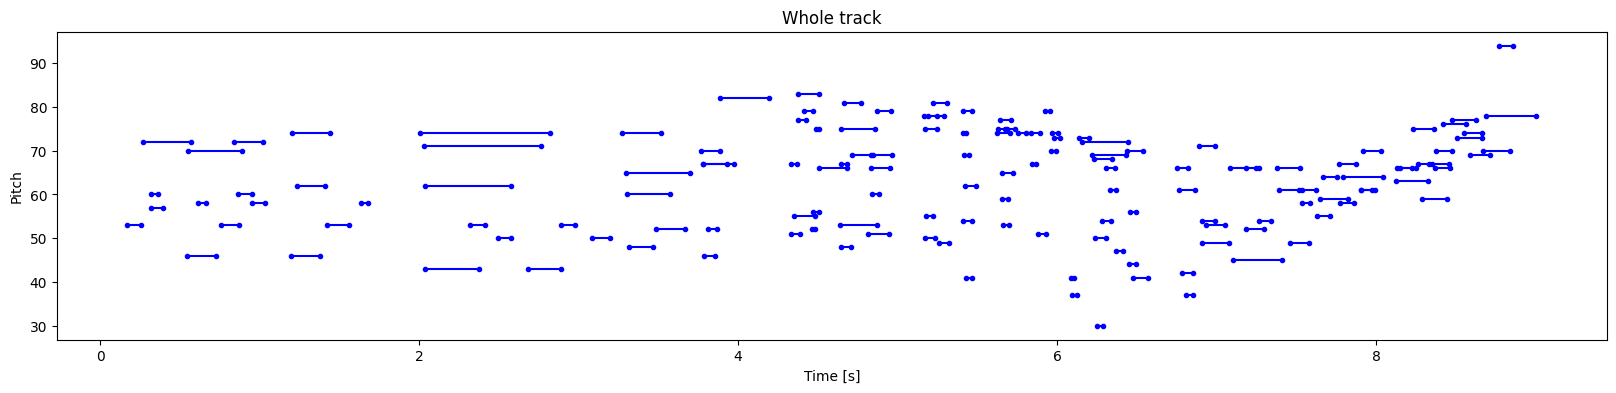

In [50]:
plot_piano_roll(generated_notes)

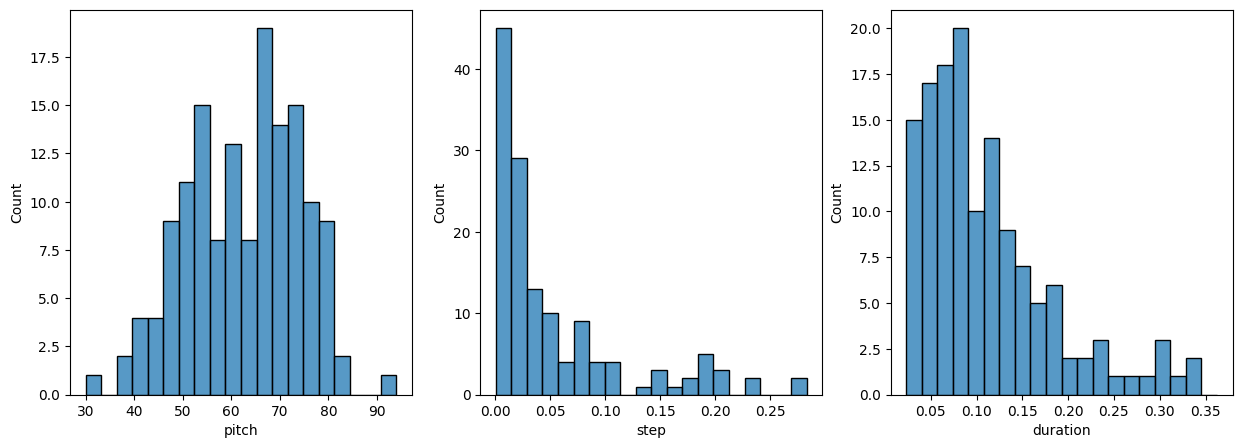

In [51]:
plot_distributions(generated_notes)

## Todo

Training/Tuning
- Increase number of files used
- Increase number of epochs
- Hyperparameter tuning (learning_rate, batch_size, hidden_dim, layers, dropout)

Formulation
- Try one_hot encoded pitch
- Try normalizing the timing variables (hopefully bring the losses within the same range)
    - More legit data-based normalization
    - Use the PyTorch transform functionality and reverse functions
    - Plotting post-transform distributions
- Ratio of teacher forcing
- Add accuracy measurement
- Layer/Batch norm
- Data augmentation
- Include note velocity
- Tokenization

Refactoring
- Ability to load a model checkpoint
- Load sequences directly from file to reduce RAM
- Plotting pitch/step/duration losses

In [54]:
pm = pretty_midi.PrettyMIDI('./norm_test/output.mid')
display_audio(pm)

In [52]:
pm = pretty_midi.PrettyMIDI('./teacher_forcing_test/output.mid')
display_audio(pm)